# A Reproducibility Analysis of 'A comprehensive metagenomics framework to characterize organisms relevant for planetary protection'
### Annaliese Meyer and Matt Baldes
#### Environmental Bioinformatics 2021

Danko et al. (2021) form a compelling case for the need for reproducible, user-friendly pipelines to facilitate the reporting of microbiomes in spacecraft assembly clean rooms. A thorough knowledge of the bioburden on spacecraft is critical to planetary protection and life detection efforts. However, despite their assertions of the necessity of reproducibility, the authors fall short in delivering a remotely useable pipeline, let alone a reproducible method for the processing of their genomic samples. In this report, we will compare figures found within Danko et al. (2021) with our best efforts at reproducing them. The code that the authors used to generate their figures was not available, so we used a number of R packages and tutorials to approximate them. We will address the numerous reporting failures found within this paper and its accompanying Github repository, and address the dangers of using completely novel in-house codes and methods rather than field standard modules for data processing.

## Background
Planetary protection is the practice of protection both the Earth and planets we interact with from contamination. One of the foremost ways to protect against contamination of other planets is through stringent cleaning practices and rigourous bioburden assessments of the clean rooms where spacecraft are assembled. At the moment, no agreed-upon best practice for assessing spacecraft and spacecraft assembly facilities exists. Further, there is no hard legislation surrounding acceptable bioburden on interplanetary spacecraft. The UN Committee on Space Research (COSPAR) provides guidelines on bioburden limits for various categories of spaces missions, but enforcement is solely at the discretion of member states. 

## Data Download
The data for this paper was stored in a repository built by the authors of this paper, rather than field standard repositories such as NCBI. This repository, Pangea, required the use of 'pangea-api' to efficiently download data more than one file at a time. This package failed to function as indicated by the documentation using the PyPi release. By rebuilding the package from the source code, we were able to download the data. 

## Attempted Methods
Our original intention in this project was to utilize the MetaSUB CAP Pipeline described in this paper, in an effort to closely follow the methods of the original authors. However, this pipeline relies on a custom pipeline manager, _ModuleUltra_. ModuleUltra failed with multiple attempts using both pip and conda installation methods, building from source, and using several different conda environments with different python versions. Given that the original CAP pipeline was deprecated and functionality had been transferred to the CAP2 pipeline, bugs existing in this first pipeline was expected. However, the CAP2 pipeline also failed to function as promised after attempting the same extensive installation and run options as the first pipeline. While we did not use either pipeline for our analyses, we did reference these pipelines to find version numbers and flags when not specified in the text. This report will differentiate between when these were explicitly mentioned in the publication versus when searching the source code was necessary. 

### Overview of Original CAP Pipeline
The original CAP pipeline is a Python pipeline managed by ModuleUltra. The pipeline consists of many 'modules' that contain several snakemake rules and metadata, and are tied together by the custom pipeline manager. ModuleUltra purportedly also allows for the installation of a user's own modules, but we did not test this functionality. The pipeline runs through quality control modules (human and macrobial read removal, adapter removal), calculates alpha diversity and beta diversity statistics, Mash Sketches, functional and taxonomy profiling, and various other statistics. The source code for this pipeline is not commented, but the file names for each step are sufficiently clear to indicate the purpose of the script. 

### Overview of CAP2 Pipeline
The CAP2 pipeline is an overhaul of the original CAP pipeline. It is built using the standard Luigi pipelining system, abandoning the snakemake and ModuleUltra combination of the previous version. CAP2 contains five subpiplines, each hosting a set of modules. These subpipeline are 'Quality Control', 'Preprocessing', 'Short Read', 'Assembly' and 'Databases'. The pipeline also includes the 'CAPalyzer', meant to provide processing tools for the output of the pipeline. While still uncommented in the bulk of the code, CAP2 contains a short blurb describing the functionality of the script, the motivation for its inclusion, and the positives and negatives of the chosen program. These blurbs provide useful background information but are not helpful in deciphering each step of the scripts.

## Figure 1
Figure 1 describes the diversity of each sample. Danko et al. (2021) use A. species level richness (i.e., the total number of detected species), B. Shannon entropy of species abundance, and C. uniform manifold and abundance. Danko et al. (2021) used a program based on Kraken called KrakenUniq to generate taxonomic profiles in order to create this figure and figure 2. While the version number for KrakenUniq was specified, the program failed on Poseidon, and the existence of multiple (>40) open issues on Github led us to believe that the issue was intrinsic to the program. As such, we used the more common program, Kraken 2. No parameters were listed for KrakenUniq in the text, and the source code for this portion was difficult to parse. Due to this fact and that we were not using the original program, we used the default parameters for Kraken 2 to analyze our data. 


We ran `kraken2` as a stand-alone program. We also attempted to run Kraken2 followed by Bracken within a pipeline developed by the Bhatt Lab (Bhatt and Siranosian, 2021) for additional robustness as indicated in the literature (source?) However, we ran into an issue with Snakemake installation that was not resolved by the time of writing. The stand-alone script is provided below:
```
for i in $(cat ${1}) #loop over sample names
do
  	cd /vortexfs1/omics/env-bio/collaboration/clean_room/output/kraken2/$i #enter sample directories to place output in specific files
        kraken2 --db /vortexfs1/omics/env-bio/collaboration/databases/kraken2db_pluspf --threads 8 --output output_default --report report_default.kreport --paired /vortexfs1/omics/env-bio/collaboration/clean_room/output/error_corrected/$i/corrected/$i.1.00.0_0.cor.fastq.gz /vortexfs1/omics/env-bio/collaboration/clean_room/output/error_corrected/$i/corrected/$i.2.00.0_0.cor.fastq.gz #run kraken2 on files within error-corrected directory and save the outputs with standard names for later processing
done

```
We proceeded using the results of the stand-alone program. Using `kraken-biom`, we converted the `kraken2` output reports for each individual sample into a binary `.biom` file that could be used in R for analysis. The script for this process is listed below. 
```
#for i in $(cat ${1}) #loop over sample names
#do
#       echo $i
#       echo /vortexfs1/omics/env-bio/collaboration/clean_room/output/kraken2/$i/report_default.kreport /vortexfs1/omics/env-bio/collaboration/clean_room/output/biom-files/$i_.kreport
#       cp /vortexfs1/omics/env-bio/collaboration/clean_room/output/kraken2/$i/report_default.kreport /vortexfs1/omics/env-bio/collaboration/clean_room/output/kraken2/$i/$i_.kreport
#       mv /vortexfs1/omics/env-bio/collaboration/clean_room/output/kraken2/$i/$i_.kreport /vortexfs1/omics/env-bio/collaboration/clean_room/output/biom-files/$i_.kreport
#done
cd /vortexfs1/omics/env-bio/collaboration/clean_room/output/biom-files/
kraken-biom 2_10.report 2_2.report 2_4.report 2_5.report 2_6.report 2_7.report 2_8.report 2_9.report 3_1.report 3_3.report 3_4.report 3_5.report 3_6.report 3_8.report 3_9.report 4_1.report 4_2.report 4_3.report 4_4.report 4_6.report 4_7.report 4_8.report -o cleanroom.biom
```
To load these data in to R, we used the `phyloseq` package (McMurdie and Holmes, 2013) `import-biom`, which converts the binary `.biom` file into an S4 object. We wrote out sample metadata in a tab-delimited text file and loaded that into R using `read.table`. We merged the two objects using `merge_phyloseq` (McMurdie and Holmes, 2013), and assigned our main sample variable, 'Grouped', which included sample type and location information, using `get_variable`. 

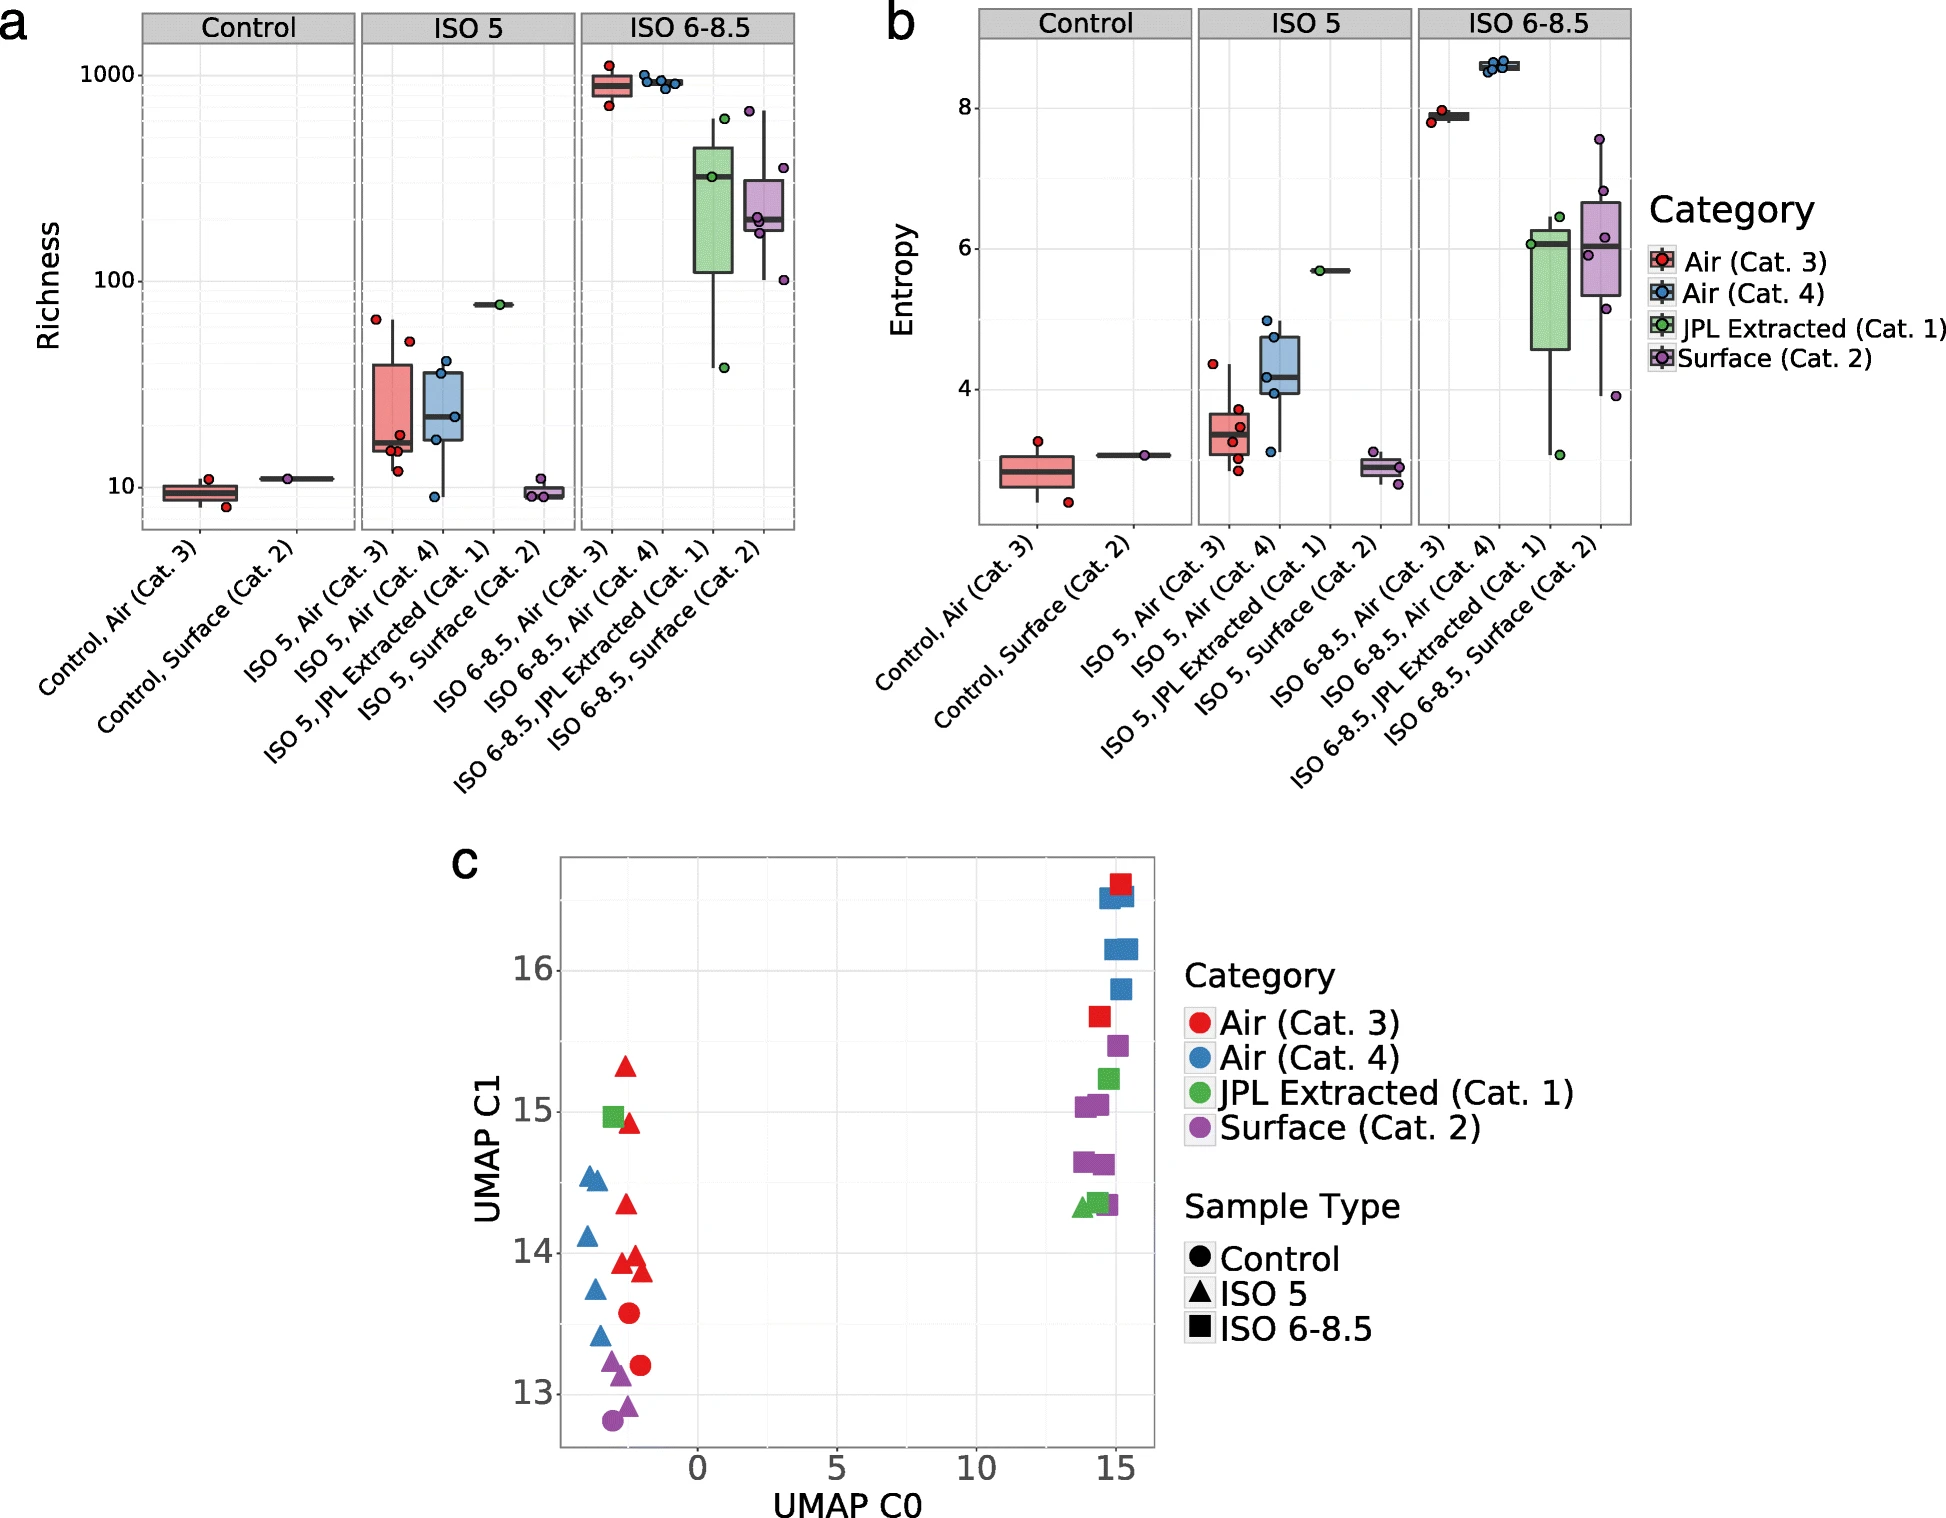

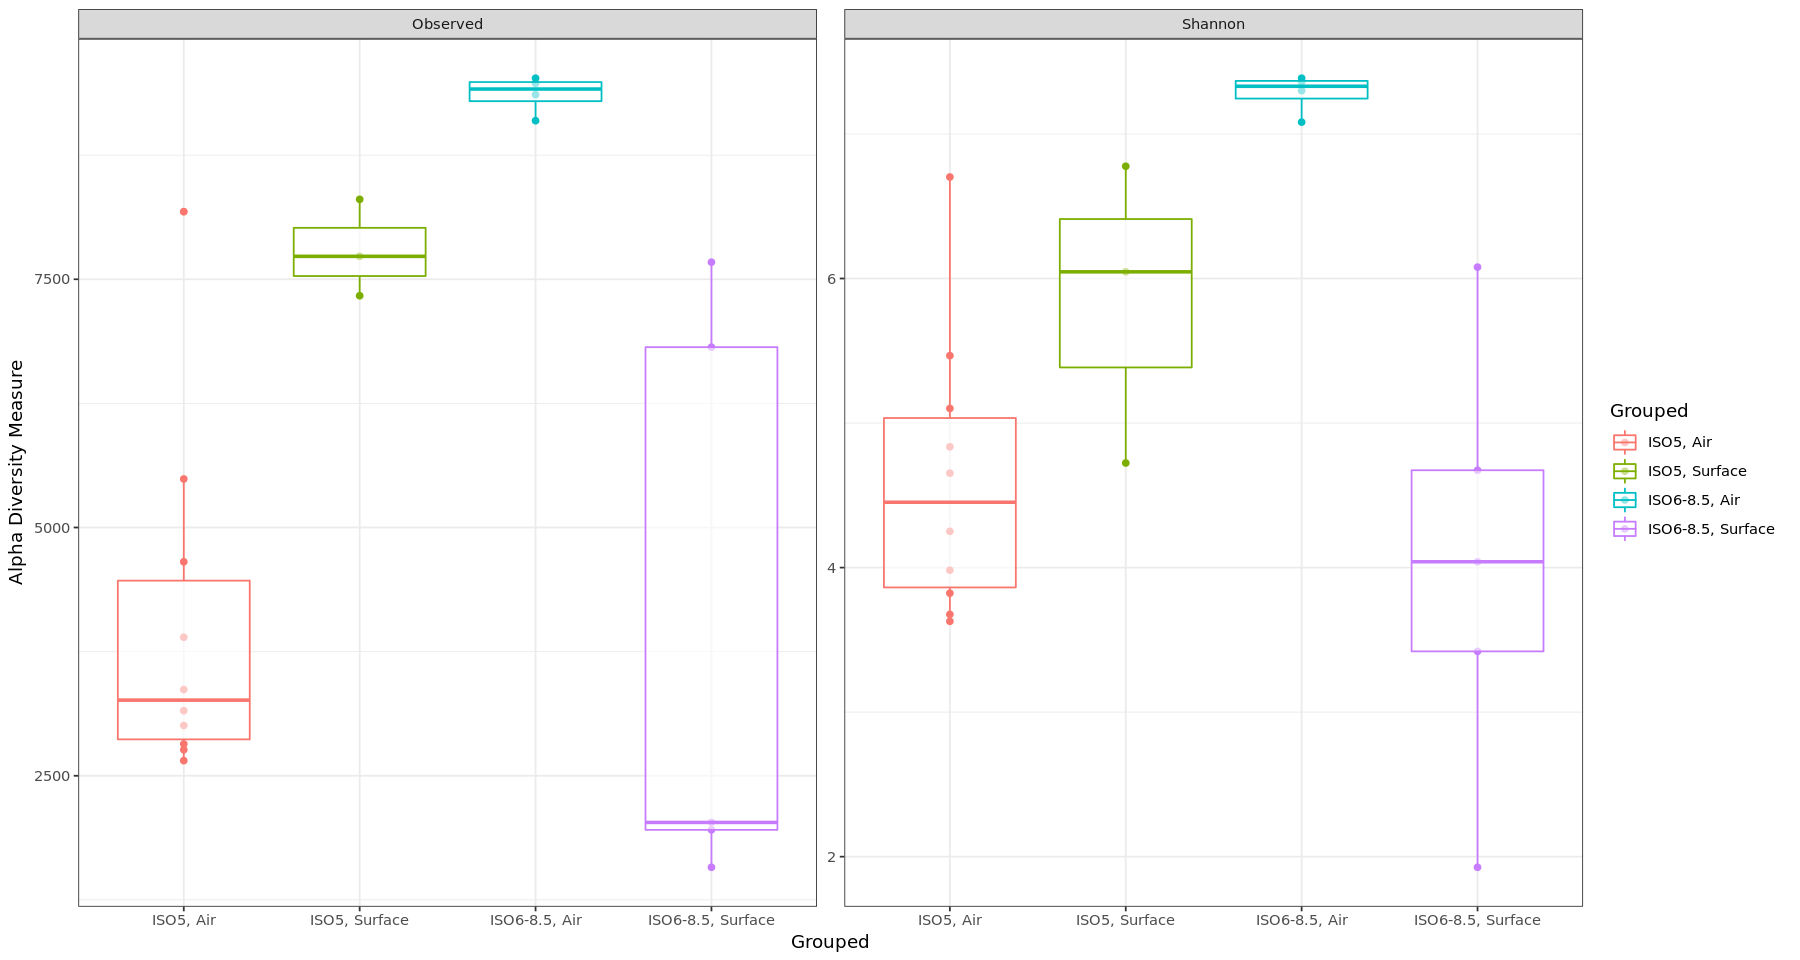

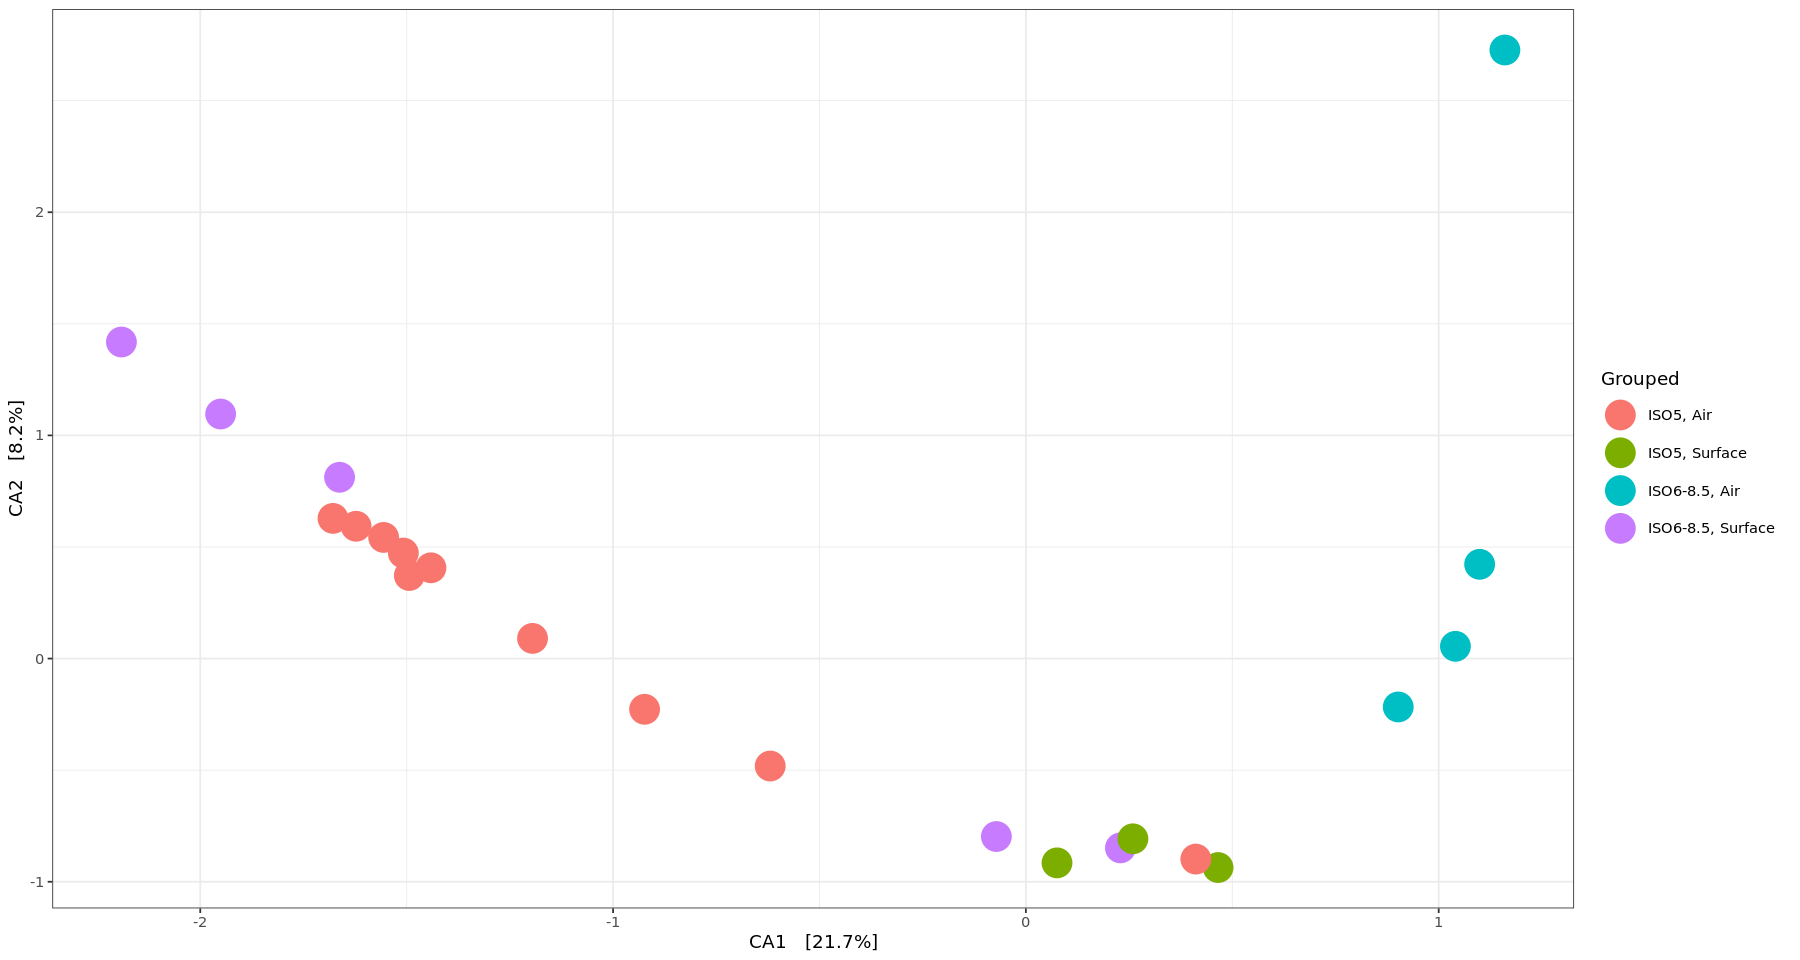

### Figure Preparation
We recreated panels A and B of Danko et al. (2021), in which they examined two alpha diversity statistics, observed species richness and Shannon entropy. Shannon entropy can be calculated as follows:

$ H(X) = - \sum \limits_{i=1}^{n}p_{i}\log_{2}p_{i}$

where $p_{i} is the proportion of species belonging to the ${i}$th species in the relevant dataset. To create these figures, we used the `plot_richness` function in the `phyloseq` library, created by McMurdie and Holmes (2013). To match the paper figures, we used the 'Observed' and 'Shannon' options for the `measures` parameter, and used 'Grouped' as both our x variable and our color determinant. We used an alpha value of 0.6. 

Panel C is a uniform manifold approximation and projection (UMAP) plot of the clean room microbiome dataset converted to binary presence/absence of taxa data. We converted the S4 object into a data frame using `psmelt` from `phyloseq` and used the following script to convert the Abundance data to presence/absence:
```
binary$Abundance[binary$Abundance != 0] <- 1
```
We also converted the abundance data within the phyloseq S4 object to presence/absence data using the `transform_sample_counts` function from `phyloseq` and the function $x/(x+1e16)$.

We first attempted to perform a UMAP analysis ourselves. We investigated multiple packages for this purpose, including `umap`, `uwot`, `scDatavia` and `yingtools2`. We were unable to either use these packages with compatible data types, or were unable to install them either on the HPC or locally due to issues with Java that due to inexperience and time constraints we did not successfully solve. 

### Comparison

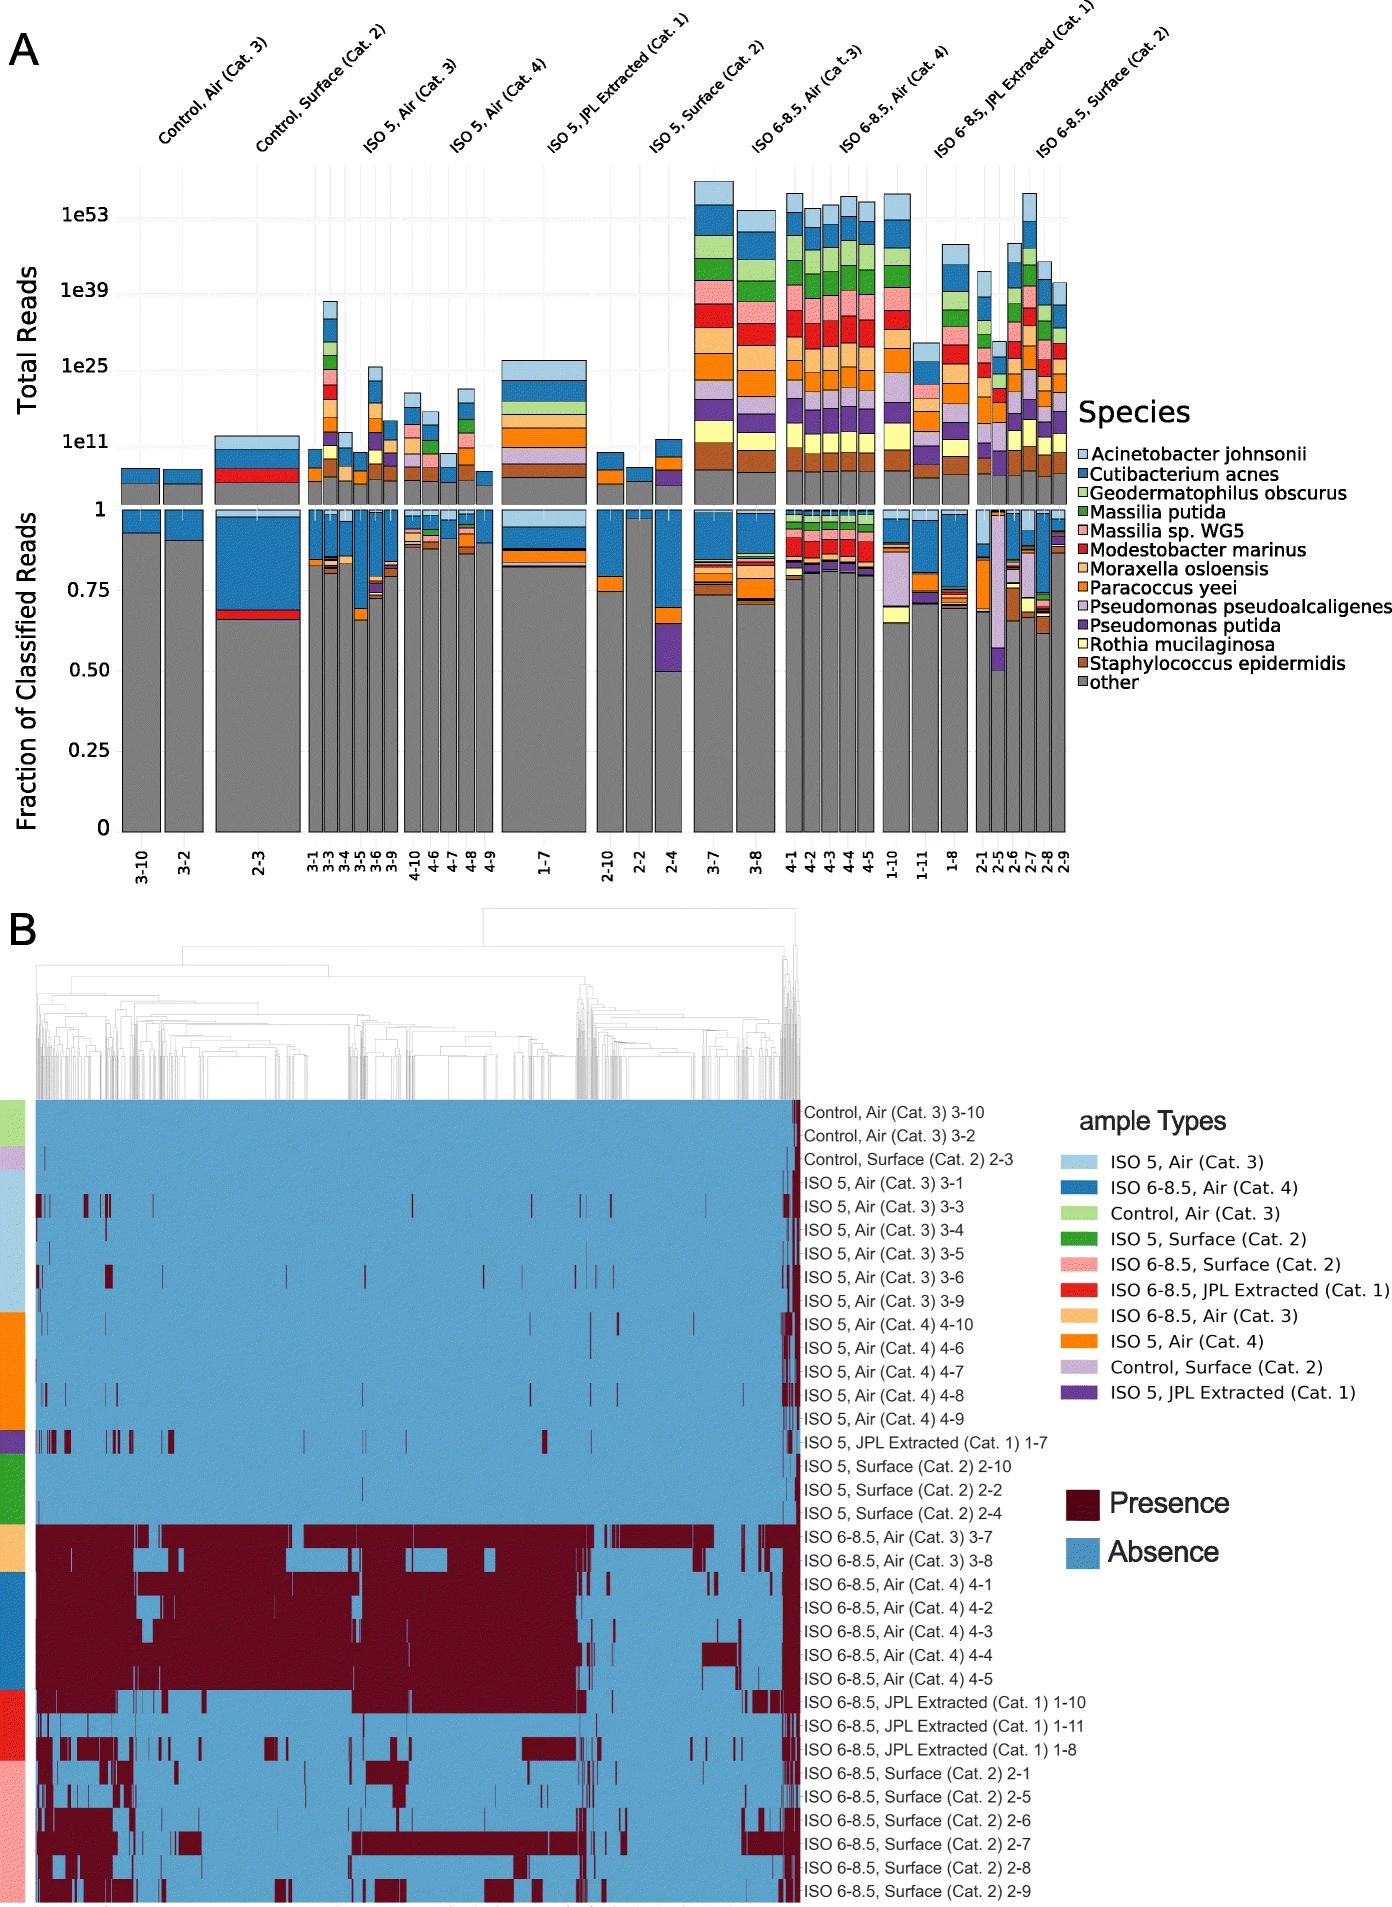

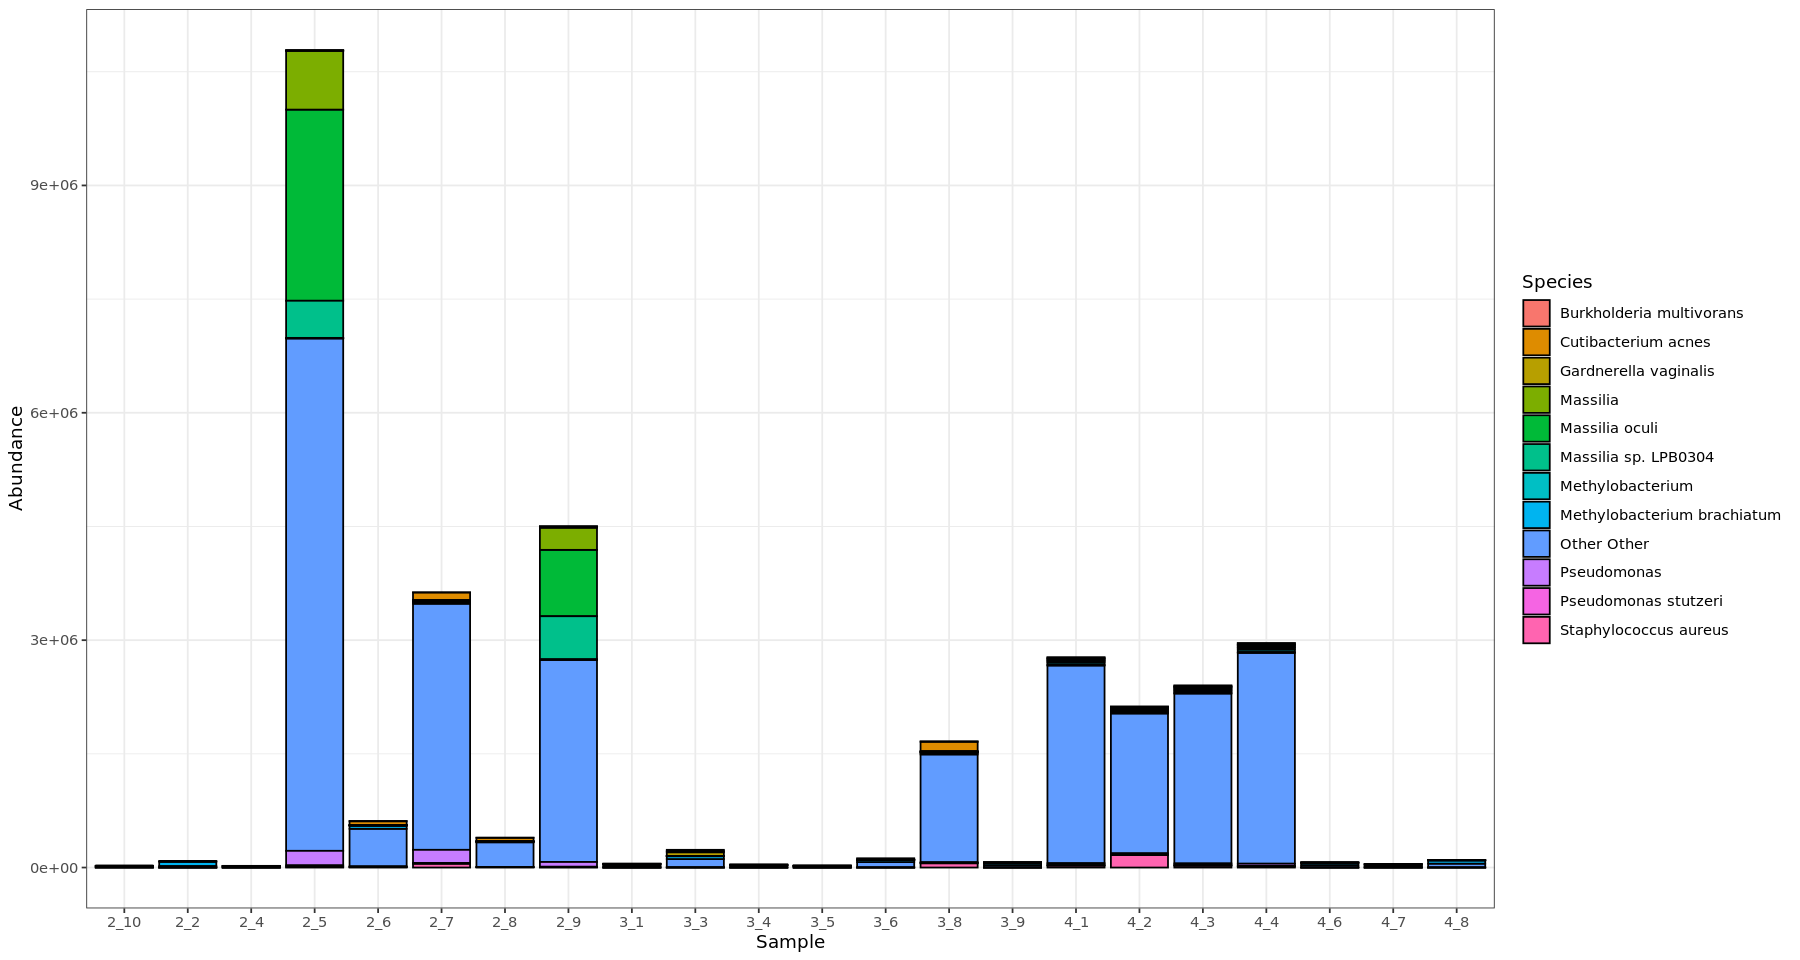

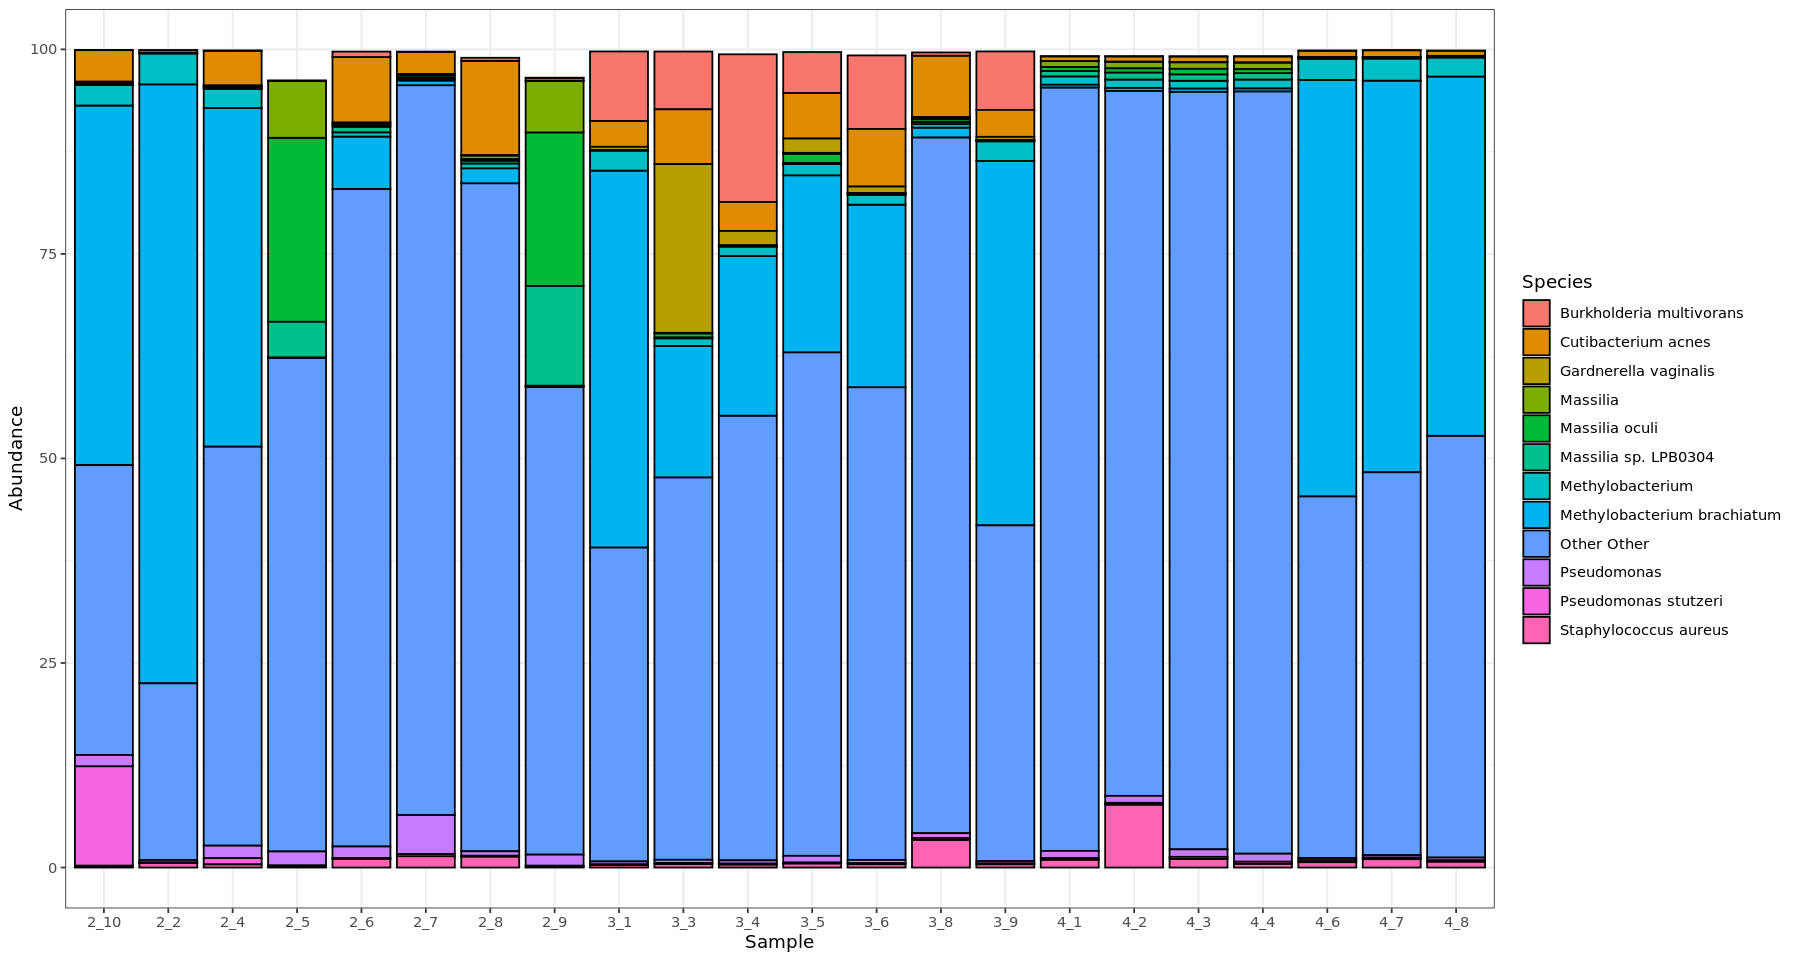

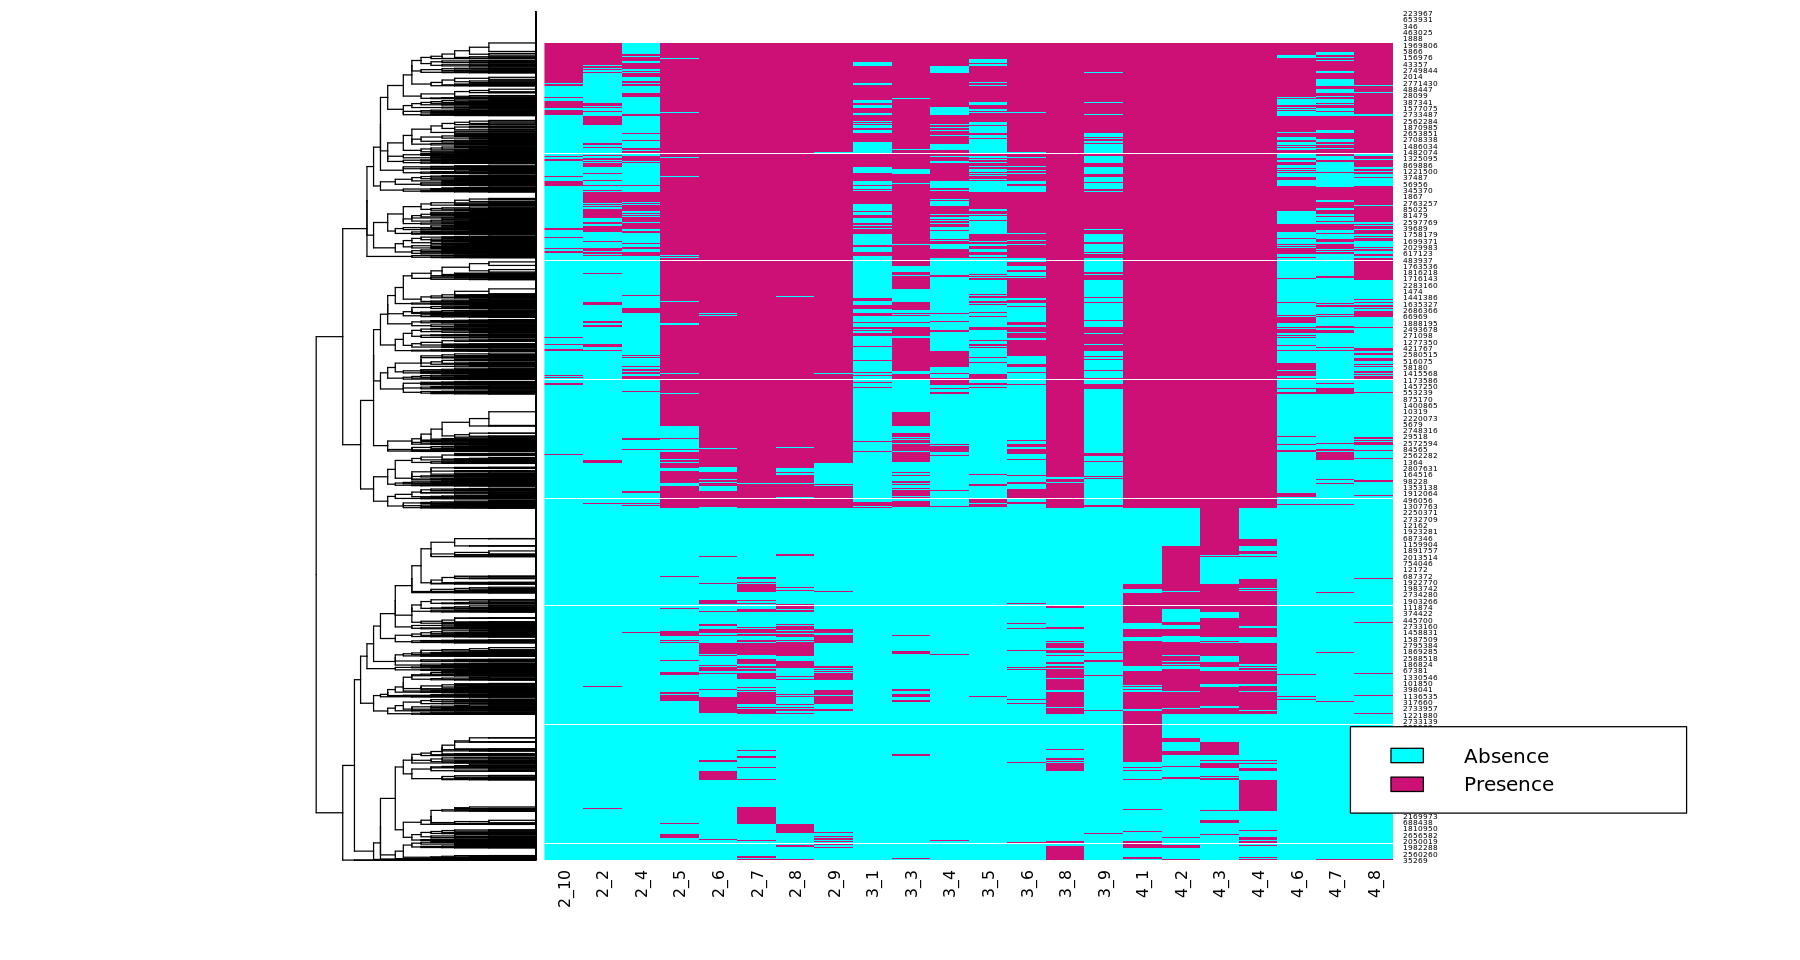

Input figure 1 here

## Other analyses
#### Jellyfish


## Final Assessment
-Grade, overall figure similarity